## **Imports**

In [1]:
""" Import Statements """

# Classics
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import squarify

import re
import spacy
from spacy.tokenizer import Tokenizer
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

In [2]:
df = pd.read_csv('cannabis.csv')

In [3]:
print('Shape:', df.shape)
df.head()

Shape: (2802, 9)


,id,name,medical,positive,negative,flavor,type,rating,description
0,0,Afpak,"Depression,Insomnia,Pain,Stress,Lack of Appetite","Relaxed,Creative,Focused,Sleepy,Happy",Dizzy,"Pine,Spicy/Herbal,Earthy",hybrid,4.2,"Afpak, named for its direct Afghani and Pakist..."
1,1,African,"Depression,Pain,Stress,Lack of Appetite,Nausea...","Euphoric,Energetic,Aroused,Tingly,Creative",Dry Mouth,"Spicy/Herbal,Pungent,Pepper",sativa,3.9,African refers to the indigenous varieties of ...
2,2,Afternoon-Delight,"Depression,Insomnia,Pain,Stress,Cramps,Headache","Talkative,Relaxed,Uplifted,Tingly,Creative","Dizzy,Dry Mouth,Paranoid","Pungent,Citrus,Tropical",hybrid,4.8,"Afternoon Delight, created by Colorado Seed In..."
3,3,Afwreck,"Pain,Stress,Headache,Fatigue,Headaches,Muscle ...","Euphoric,Happy,Uplifted,Relaxed,Sleepy","Dizzy,Dry Mouth,Paranoid,Dry Eyes","Earthy,Pine,Pungent",hybrid,4.2,Afwreck is a hybrid cross of Afghani and Train...
4,4,Agent-Orange,"Depression,Pain,Stress,Nausea,Headache,Headaches","Happy,Uplifted,Relaxed,Energetic,Euphoric","Dizzy,Dry Mouth,Paranoid,Dry Eyes","Citrus,Orange,Earthy",hybrid,4.2,Don’t let the name scare you! The only herbici...


## **Data Cleaning**

In [4]:
df.isnull().sum()

id                0
name              0
medical         885
positive        451
negative       1220
flavor          497
type            451
rating          451
description     484
dtype: int64

In [5]:
df = df.dropna(subset=['medical'], axis=0)

In [6]:
df.shape

(1917, 9)

In [7]:
df.isnull().sum()

id               0
name             0
medical          0
positive       430
negative       359
flavor         430
type           430
rating         430
description    452
dtype: int64

In [8]:
df.isnull().sum()

id               0
name             0
medical          0
positive       430
negative       359
flavor         430
type           430
rating         430
description    452
dtype: int64

In [9]:
df['positive'] = df['positive'].replace(np.nan, 'positive effects currently unknown')
df['negative'] = df['negative'].replace(np.nan, 'negative effects currently unknown')
df['flavor'] = df['flavor'].replace(np.nan, 'flavor currently unavailable')
df['type'] = df['type'].replace(np.nan, 'type is unknown')
df['description'] = df['description'].replace(np.nan, 'no strain description')
df['rating'] = df['rating'].replace(np.nan, 0)

In [10]:
df.isnull().sum()

id             0
name           0
medical        0
positive       0
negative       0
flavor         0
type           0
rating         0
description    0
dtype: int64

## **Tokenizing**

### Creating a corpus

In [11]:
#Combining features to create a strain profile
df['strain_profile'] = df['medical'] + ' ' + df['positive'] + ' ' + df['negative'] + ' ' + df['flavor'] + ' ' + df['type'] + ' ' + df['description'] + ' '

In [12]:
#Doing some manual cleaning 

#Lowercase text
df['strain_profile'] = df['strain_profile'].apply(lambda x: x.lower())

#Remove symbols
df['strain_profile'] = df['strain_profile'].apply(lambda x: re.sub('[^a-zA-Z 0-9]', ' ', x))

In [13]:
df.head()

,id,name,medical,positive,negative,flavor,type,rating,description,strain_profile
0,0,Afpak,"Depression,Insomnia,Pain,Stress,Lack of Appetite","Relaxed,Creative,Focused,Sleepy,Happy",Dizzy,"Pine,Spicy/Herbal,Earthy",hybrid,4.2,"Afpak, named for its direct Afghani and Pakist...",depression insomnia pain stress lack of appeti...
1,1,African,"Depression,Pain,Stress,Lack of Appetite,Nausea...","Euphoric,Energetic,Aroused,Tingly,Creative",Dry Mouth,"Spicy/Herbal,Pungent,Pepper",sativa,3.9,African refers to the indigenous varieties of ...,depression pain stress lack of appetite nausea...
2,2,Afternoon-Delight,"Depression,Insomnia,Pain,Stress,Cramps,Headache","Talkative,Relaxed,Uplifted,Tingly,Creative","Dizzy,Dry Mouth,Paranoid","Pungent,Citrus,Tropical",hybrid,4.8,"Afternoon Delight, created by Colorado Seed In...",depression insomnia pain stress cramps headach...
3,3,Afwreck,"Pain,Stress,Headache,Fatigue,Headaches,Muscle ...","Euphoric,Happy,Uplifted,Relaxed,Sleepy","Dizzy,Dry Mouth,Paranoid,Dry Eyes","Earthy,Pine,Pungent",hybrid,4.2,Afwreck is a hybrid cross of Afghani and Train...,pain stress headache fatigue headaches muscle ...
4,4,Agent-Orange,"Depression,Pain,Stress,Nausea,Headache,Headaches","Happy,Uplifted,Relaxed,Energetic,Euphoric","Dizzy,Dry Mouth,Paranoid,Dry Eyes","Citrus,Orange,Earthy",hybrid,4.2,Don’t let the name scare you! The only herbici...,depression pain stress nausea headache headach...


### spaCy s

In [14]:
nlp = spacy.load("en_core_web_lg")

In [15]:
STOP_WORDS = nlp.Defaults.stop_words.union({"$", 'strain','', "flower", None, '-', ' ',"it's", 'i', "i'm", "i've", "it's", "don't", '-', 'got', 'it.',  'weed', 'effects', 'effect', 'high', 'consumer', 'breed', 'unkown', 'unavailable'})

In [16]:
def tokenize(text):
  doc = nlp(str(text)) #casting as text
  return [token.lemma_.strip() for token in doc if (token.text.lower() not in STOP_WORDS) and (token.is_punct !=True)]

In [17]:
df['tokens'] = df['strain_profile'].apply(tokenize)

In [18]:
df['tokens']

0       [depression, insomnia, pain, stress, lack, app...
1       [depression, pain, stress, lack, appetite, nau...
2       [depression, insomnia, pain, stress, cramp, he...
3       [pain, stress, headache, fatigue, headache, mu...
4       [depression, pain, stress, nausea, headache, h...
                              ...                        
1966    [depression, insomnia, pain, stress, fatigue, ...
1967    [depression, insomnia, pain, stress, nausea, h...
1968    [depression, insomnia, pain, stress, lack, app...
1969    [insomnia, pain, cramp, lack, appetite, muscle...
1970    [depression, stress, fatigue, positive, curren...
Name: tokens, Length: 1917, dtype: object

In [19]:
# Gut check

# Object from Base Python

word_counts = Counter()

# Update it based on a split of each of our documents
df["tokens"].apply(lambda x: word_counts.update(x))

# Print out the 20 most common words
word_counts.most_common(20)

[('dry', 2591),
 ('stress', 1925),
 ('pain', 1869),
 ('depression', 1657),
 ('hybrid', 1615),
 ('mouth', 1409),
 ('eye', 1375),
 ('happy', 1373),
 ('sweet', 1346),
 ('indica', 1329),
 ('unknown', 1246),
 ('currently', 1220),
 ('euphoric', 1215),
 ('headache', 1172),
 ('sativa', 1082),
 ('earthy', 968),
 ('insomnia', 956),
 ('flavor', 920),
 ('uplifted', 874),
 ('appetite', 821)]

In [20]:
def count(docs):
        word_counts = Counter()
        appears_in = Counter()
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [21]:
wc = count(df["tokens"])
wc.head(50)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
85,dry,1498,2591,1.0,0.025453,0.025453,0.781429
35,stress,1724,1925,2.0,0.018910,0.044363,0.899322
6,pain,1559,1869,3.0,0.018360,0.062723,0.813250
12,depression,1559,1657,4.0,0.016278,0.079001,0.813250
50,hybrid,919,1615,5.0,0.015865,0.094866,0.479395
77,mouth,1408,1409,6.0,0.013841,0.108708,0.734481
122,eye,1271,1375,7.0,0.013507,0.122215,0.663015
33,happy,1298,1373,8.0,0.013488,0.135703,0.677100
272,sweet,967,1346,9.0,0.013223,0.148925,0.504434
40,indica,719,1329,10.0,0.013056,0.161981,0.375065


### Visualize tokens

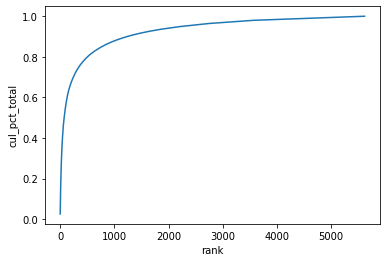

In [22]:
sns.lineplot(x='rank', y='cul_pct_total', data=wc);

In [23]:
# Percentage of the the top 200 words

wc[wc['rank'] <= 200]['cul_pct_total'].max()

0.6711560375653268

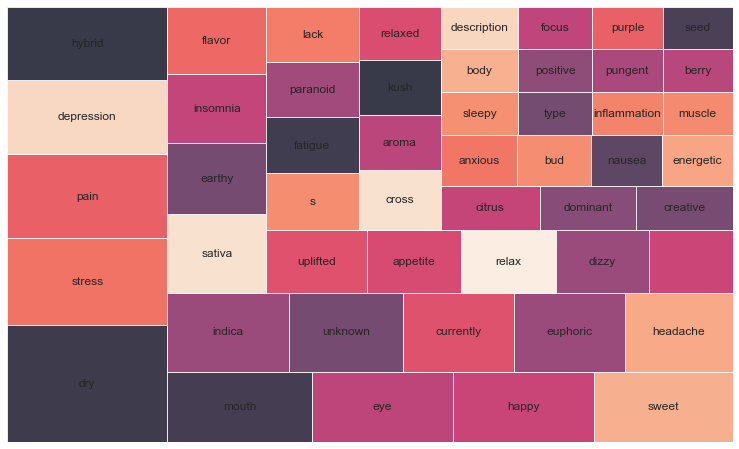

In [24]:
sns.set(rc={'figure.figsize':(13,8)})

wc_top20 = wc[wc['rank'] <= 50]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

## Vectorization

### TFIDF

In [25]:
def gather_data(df_column):
    """ Produces List of Documents from a df c(olumn    
    returns list of strings 
    """
    data = []
    for row in df_column:
        data.append(' '.join(row))
    return data

In [26]:
data = gather_data(df['tokens'])

In [27]:
# Instantiate vectorizer object
tfidf = TfidfVectorizer(stop_words='english', 
                        ngram_range=(1,2),
                        max_df=.97,
                        min_df=3,
                        tokenizer=tokenize,
                        max_features = 5000)

# Create a vocabulary and get word counts per document
dtm = tfidf.fit_transform(data) # Similiar to fit_predict

# Print word counts

# Get feature names to use as dataframe column headers
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame
dtm.head()

,0,1,1 1,1 2,1 cbd,1 hybrid,1 ratio,10,10 11,10 week,...,yield potency,yield resinous,yield sativa,yield sweet,yield thc,yielder,zest,zesty,zesty lemon,zombie
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


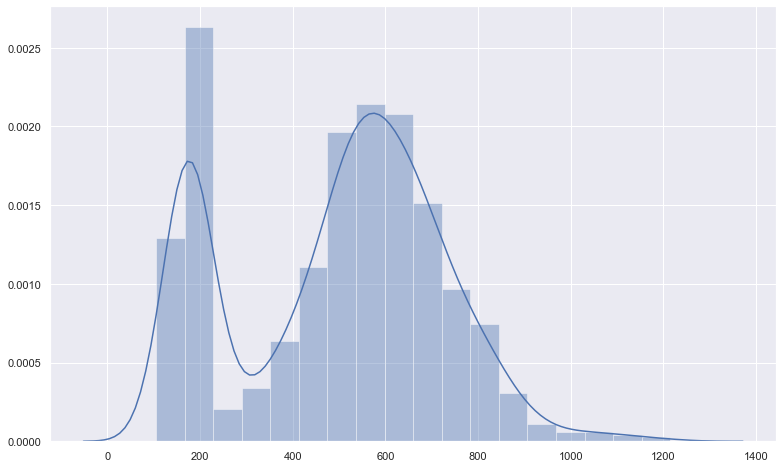

In [28]:
# Visualize document length distribution of Description data set

doc_len = [len(doc) for doc in df['strain_profile']]

sns.distplot(doc_len);

# ML Model

## Nearest Neighbors model

In [29]:
nn = NearestNeighbors(n_neighbors=5, algorithm = "kd_tree")
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [30]:
user_input = ['I am suffering from headaches. Looking for a sweet flavor and being uplifted and energetic.']

In [31]:
user_dense = tfidf.transform(user_input)
nn_user = nn.kneighbors(user_dense.todense())

In [32]:
nn_user

(array([[1.28523577, 1.30172174, 1.30392966, 1.30714738, 1.31556255]]),
 array([[ 537,  741, 1666,  677, 1440]]))

In [39]:
df['strain_profile'][537]

'depression pain stress uplifted tingly relaxed euphoric aroused dry mouth lemon earthy pungent hybrid critters cookies blends the power of cookies  parentage with the energy driven hybrid white fire alien og to offer an aroma of distinct lemon funk with a sweet cakiness that lingers in the air  the strain is a balanced 60 40 sativa leaning cross that is equal parts energizing and relaxing  and is naturally suited for physical discomfort and pain  '

In [40]:
df['strain_profile'][741]

'depression pain headaches positive effects currently unknown negative effects currently unknown flavor currently unavailable type is unknown no strain description '

In [41]:
df['strain_profile'][1666]

'depression pain stress lack of appetite nausea relaxed happy uplifted energetic euphoric dizzy dry mouth dry eyes strawberry sweet berry sativa strawberry blue is a 75  sativa bred by world of seeds that crosses strawberry and new blue line  these lanky buds are favored for their notable sweet  fruity aroma and provide heady effects true to its sativa heritage  indoor or outdoor grows offer comparable yields  with a flowering time of around 9 weeks  '

In [42]:
df['strain_profile'][677]

'depression insomnia pain nausea inflammation relaxed happy sleepy giggly euphoric dry mouth dry eyes citrus pungent flowery indica the indica dominant enigma strain is as mysterious as its name makes it sound  not much is known about its origins  but enigma is a long lasting euphoric strain with earthy and tangy flavors  the natural progression of its effects begins with carefree happiness and ends in a sleepy haze  enigma is a great strain for patients experiencing appetite loss and or cachexia  '

In [43]:
df['strain_profile'][1440]

'depression pain stress headache fatigue inflammation happy uplifted euphoric energetic talkative dizzy dry mouth dry eyes anxious earthy pungent woody sativa power plant comes from dutch passion seed company and is derived from powerful south african sativa strains  thanks to this  these plants have a fast growing time compared to most sativas and will produce either many medium sized flowers or a few very large buds with smaller  popcorn  buds between 7 and 9 weeks  these plants are troopers and will do well in almost any grow environment  but its woody  earthy scent is pungent  so indoor growers will have to prepare  power plant has a sharp  peppery taste  while many sativas are good choices for a clear headed buzz  this plant s high thc content makes it powerful  it makes some users happy and creative  though effects may verge on too intoxicating for some  '

## Cosine Similarity

In [36]:
dist_matrix = cosine_similarity(dtm)

In [38]:
cosine_df = pd.DataFrame(dist_matrix)
print(cosine_df.shape)
cosine_df.head()

(1917, 1917)


,0,1,2,3,4,5,6,7,8,9,...,1907,1908,1909,1910,1911,1912,1913,1914,1915,1916
0,1.000000,0.062845,0.057062,0.071721,0.049538,0.095086,0.059954,0.029439,0.035877,0.044497,...,0.085269,0.131588,0.059559,0.058529,0.046691,0.037380,0.081104,0.070427,0.085962,0.012249
1,0.062845,1.000000,0.048201,0.034076,0.025470,0.012598,0.038789,0.023479,0.051083,0.049581,...,0.048810,0.056925,0.047060,0.031213,0.052738,0.021341,0.026383,0.052997,0.048804,0.012666
2,0.057062,0.048201,1.000000,0.130195,0.038810,0.052044,0.022509,0.023574,0.024506,0.043415,...,0.099363,0.072463,0.070432,0.066689,0.043015,0.072621,0.046413,0.075501,0.056433,0.041308
3,0.071721,0.034076,0.130195,1.000000,0.090357,0.041827,0.069982,0.023776,0.069941,0.150909,...,0.057019,0.198282,0.069803,0.077389,0.048688,0.122657,0.063932,0.123055,0.039259,0.076107
4,0.049538,0.025470,0.038810,0.090357,1.000000,0.147710,0.040194,0.013505,0.049303,0.031028,...,0.072054,0.060961,0.080408,0.064914,0.065453,0.063069,0.051967,0.069094,0.009920,0.039429


TO DO:
- create cosine model (see which has better results)
- try a different algorithm for nn model
- create a loop that can print all the recommendations for the nn model
- Visualizations 